# Machine Translation
1- Import Dependanices

2- import dataset for training

3- Basic EDA and visualization

4- Data Cleaning

5- Tokenization and build vocabalury

6- Pad Sequence and Vectorization

7- Train model

8- Predictions


# Import Libraries

In [107]:
# basic libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import seaborn as sns
%matplotlib inline

# cleaning data
import re
import os
import nltk
nltk.download("stopwords")
nltk.download('punkt')

# save vocabulary in files
import pickle

# tokenization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,LSTM, Dropout
from tensorflow.keras.layers import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import ModelCheckpoint

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Import Dataset

In [108]:
df = pd.read_csv("ara_eng.txt",delimiter="\t",names=["English","Arabic"])
df.head()

,English,Arabic
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Help!,النجدة!
3,Jump!,اقفز!
4,Stop!,قف!


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24638 entries, 0 to 24637
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   English  24638 non-null  object
 1   Arabic   24638 non-null  object
dtypes: object(2)
memory usage: 385.1+ KB


In [110]:
df = df [:20000]

# Basic EDA and visualization

In [111]:
english_sentences = df['English']
arabic_sentences = df['Arabic']
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
arabic_words_counter = collections.Counter([word for sentence in arabic_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} Arabic words.'.format(len([word for sentence in arabic_sentences for word in sentence.split()])))
print('{} unique Arabic words.'.format(len(arabic_words_counter)))
print('10 Most common words in the Arabic dataset:')
print('"' + '" "'.join(list(zip(*arabic_words_counter.most_common(10)))[0]) + '"')

302085 English words.
26133 unique English words.
10 Most common words in the English dataset:
"the" "to" "of" "a" "in" "and" "is" "on" "for" "I"

256663 Arabic words.
48743 unique Arabic words.
10 Most common words in the Arabic dataset:
"في" "من" "على" "ان" "عن" "العالمية" "الاصوات" "لا" "هذا" "الى"


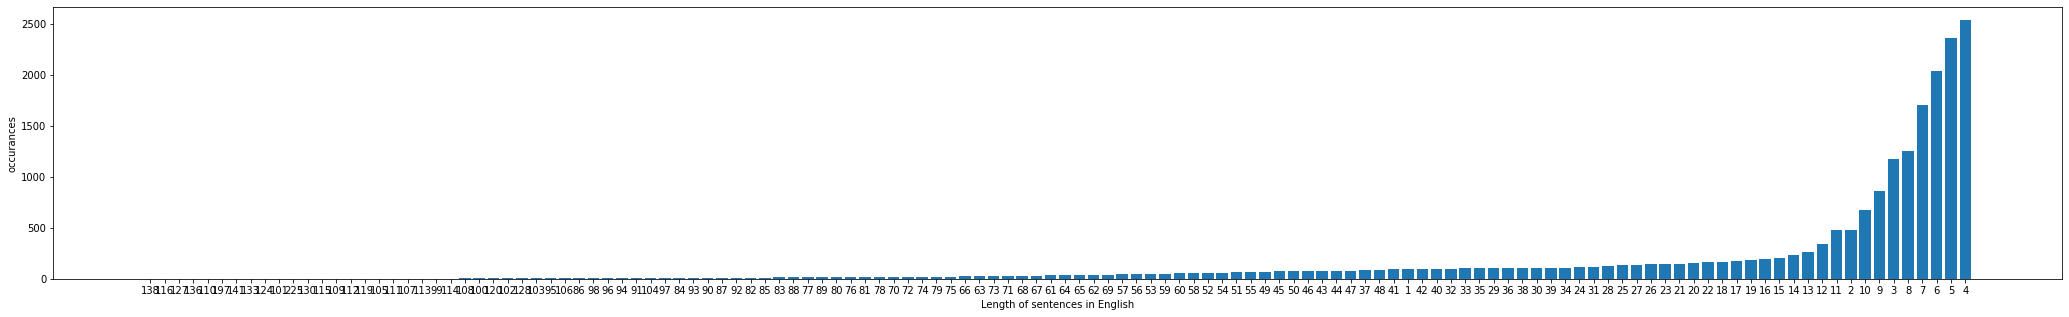

In [112]:
word_count = df['English'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))
index  = np.arange(len(word_dict))
values1 = word_dict.values()
plt.figure(figsize=(36,5))
plt.bar(index,values1)
plt.xlabel('Length of sentences in English')
plt.ylabel('occurances')
plt.xticks(index,word_dict.keys())
plt.show()

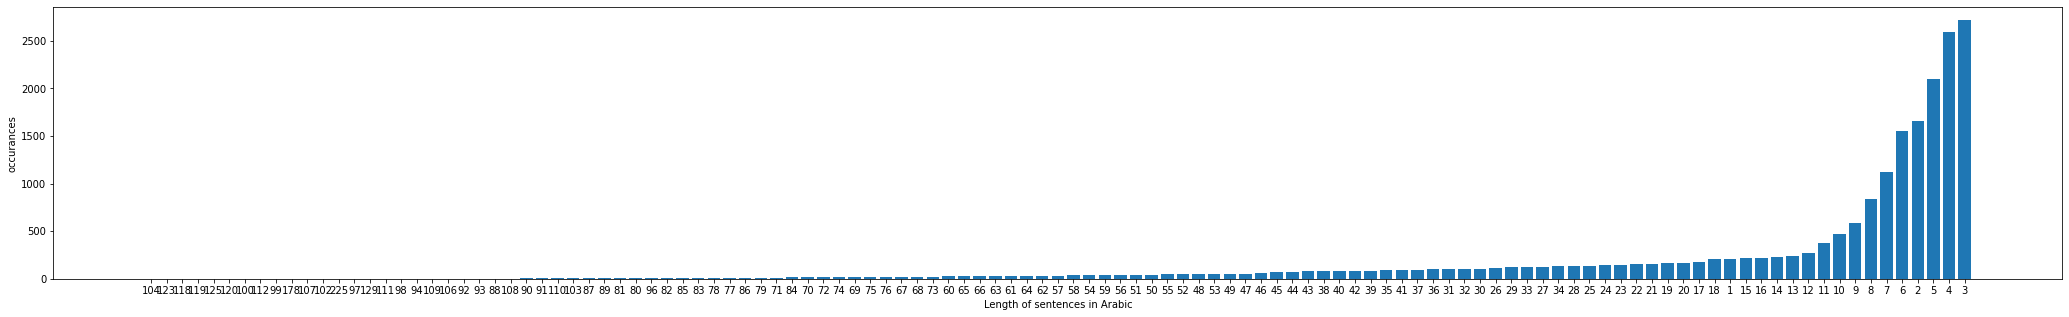

In [113]:
word_count = df['Arabic'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))
index  = np.arange(len(word_dict))
values1 = word_dict.values()
plt.figure(figsize=(36,5))
plt.bar(index,values1)
plt.xlabel('Length of sentences in Arabic')
plt.ylabel('occurances')
plt.xticks(index,word_dict.keys())
plt.show()

# Data Cleaning

In [114]:
# clean english column
def clean_english(text):
  text=text.lower() # lower case

  # remove any characters not a-z and ?!,'
  text=re.sub(u"[^a-z!?',]"," ",text)

  # word tokenization
  text=nltk.word_tokenize(text)

  # join text
  text=" ".join([i.strip() for i in text])

  return text

In [115]:
df["English"]=df["English"].apply(lambda txt:clean_english(txt))

In [116]:
### We won't need to clean arabic text

# Tokenization

In [117]:
def tokenize(x):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

# Padding

In [118]:
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = 55, padding = 'post')

# Preprocess pipeline

In [119]:
def preprocess(x, y):
   
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

In [120]:
preproc_english_sentences, preproc_arabic_sentences, english_tokenizer, arabic_tokenizer = preprocess(english_sentences, arabic_sentences)

In [121]:
max_english_sequence_length = preproc_english_sentences.shape[1]
max_arabic_sequence_length = preproc_arabic_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
arabic_vocab_size = len(arabic_tokenizer.word_index)

In [122]:
print("Max English sentence length:", max_english_sequence_length)
print("Max Arabic sentence length:", max_arabic_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("Arabic vocabulary size:", arabic_vocab_size)

Max English sentence length: 55
Max Arabic sentence length: 55
English vocabulary size: 20569
Arabic vocabulary size: 46300


 Convert the final prediction by our model into text form

In [123]:
def logits_to_text(logits, tokenizer):
    
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

# Model

In [124]:
def model(input_shape, output_sequence_length, english_vocab_size, arabic_vocab_size):
    
    learning_rate = 0.003
    
    # Build the layers
    model = Sequential()
    model.add(Embedding(arabic_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(Bidirectional(GRU(256, return_sequences=True)))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(english_vocab_size, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [125]:
preproc_english_sentences.shape

(20000, 55)

In [126]:
tmp_x = pad(preproc_arabic_sentences, preproc_arabic_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_arabic_sentences.shape[-2]))

In [127]:
model = model(
    tmp_x.shape,
    preproc_english_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(arabic_tokenizer.word_index)+1)

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 55, 256)           11853056  
                                                                 
 bidirectional_3 (Bidirectio  (None, 55, 512)          789504    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 55, 1024)         525312    
 tributed)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 55, 1024)          0         
                                                                 
 time_distributed_7 (TimeDis  (None, 55, 20570)        21084250  
 tributed)                                                       
                                                      

In [128]:
model.fit(tmp_x, preproc_english_sentences, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 72s 276ms/step - loss: 1.7927 - accuracy: 0.7880 - val_loss: 3.3997 - val_accuracy: 0.5735
Epoch 2/10
250/250 [==============================] - 67s 268ms/step - loss: 1.5002 - accuracy: 0.7984 - val_loss: 3.4090 - val_accuracy: 0.5752
Epoch 3/10
250/250 [==============================] - 63s 250ms/step - loss: 1.3901 - accuracy: 0.8059 - val_loss: 3.4564 - val_accuracy: 0.5746
Epoch 4/10
250/250 [==============================] - 67s 268ms/step - loss: 1.2835 - accuracy: 0.8131 - val_loss: 3.5232 - val_accuracy: 0.5697
Epoch 5/10
250/250 [==============================] - 62s 250ms/step - loss: 1.1762 - accuracy: 0.8211 - val_loss: 3.5950 - val_accuracy: 0.5710
Epoch 6/10
250/250 [==============================] - 67s 268ms/step - loss: 1.0642 - accuracy: 0.8303 - val_loss: 3.7025 - val_accuracy: 0.5703
Epoch 7/10
250/250 [==============================] - 62s 249ms/step - loss: 0.9532 - accuracy: 0.8406 - val_loss: 3.8272 - val_ac

In [129]:
model.save('model.h5')

# Predictions

In [130]:
def translation(i):
  print ("Arabic text:", arabic_sentences[i])
  print ("\nEnglish Translation:", english_sentences[i])
  print ("\nTranslation:", logits_to_text(model.predict(tmp_x[[i]])[0], english_tokenizer))

In [131]:
print(translation(680))

Arabic text: أنا لستُ سعيدة.

English Translation: i 'm not happy
1/1 [==============================] - 1s 707ms/step

Translation: i 'm not happy <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
None


In [132]:
print(translation(220))

Arabic text: تعال بسرعة.

English Translation: come quick !
1/1 [==============================] - 0s 20ms/step

Translation: come quick <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
None


In [133]:
print(translation(114))

Arabic text: تعال إلى هنا.

English Translation: come here
1/1 [==============================] - 0s 19ms/step

Translation: come here here <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
None
